In [1]:
# 1) (Optional) Installs — uncomment on first run
# !pip install -U matplotlib timm torchvision torch tqdm scikit-learn --quiet
!pip install -U open-clip-torch torchinfo --quiet
print('If you need packages, uncomment the pip lines above and run this cell.')

If you need packages, uncomment the pip lines above and run this cell.


In [2]:
# 2) Common imports + seeds
import math, random, os, time
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets, transforms

import torchinfo

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import open_clip

def set_seed(seed:int=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device is {device}")

Device is cuda


In [3]:
from dataclasses import dataclass
from typing import Tuple

# Pick a lightweight variant for quick experiments


@dataclass
class Config:
    #model_name: str = "ViT-B-32"  # new MobileCLIP2 in open_clip
    #pretrained: str = "laion2b_s34b_b79k"
    model_name = 'MobileCLIP2-S0'   # alternatives: 'MobileCLIP2-S2', 'MobileCLIP2-B', 'MobileCLIP2-S3', 'MobileCLIP2-S4', 'MobileCLIP2-L-14'
    pretrained = 'dfndr2b'          # per MobileCLIP2 release in OpenCLIP

    dataset = 'cifar10'

    image_size: int = 224
    batch_size: int = 256
    num_workers: int = 4
    max_epochs: int = 10

    # LR split: base vs prompt
    lr_base: float = 1e-5
    lr_prompt: float = 5e-3
    weight_decay: float = 0.05

    # Unfreeze (if you want a light finetune on top of prompt)
    unfreeze_layers: Tuple[str, ...] = tuple()  # e.g. ("visual.transformer.resblocks.11",)

    # CoOp prompt length
    prompt_len: int = 16

    # Overfit sanity tiny subset
    overfit_n_classes: int = 2
    overfit_k_per_class: int = 8
    overfit_epochs: int = 50


cfg = Config()
cfg


Config(image_size=224, batch_size=256, num_workers=4, max_epochs=10, lr_base=1e-05, lr_prompt=0.005, weight_decay=0.05, unfreeze_layers=(), prompt_len=16, overfit_n_classes=2, overfit_k_per_class=8, overfit_epochs=50)

In [4]:
# --- Load model + preprocess ---
model, _, preprocess = open_clip.create_model_and_transforms(cfg.model_name, pretrained=cfg.pretrained)
tokenizer = open_clip.get_tokenizer(cfg.model_name)
model = model.to(device).eval()
#text_tower = getattr(model, "text", model)

torchinfo.summary(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Layer (type:depth-idx)                                                           Param #
CustomTextCLIP                                                                   1
├─TimmModel: 1-1                                                                 --
│    └─FastVit: 2-1                                                              --
│    │    └─Sequential: 3-1                                                      7,424
│    │    └─Sequential: 3-2                                                      10,728,256
│    │    └─MobileOneBlock: 3-3                                                  146,496
│    │    └─ClassifierHead: 3-4                                                  524,800
│    └─Sequential: 2-2                                                           --
├─TextTransformer: 1-2                                                           301,568
│    └─Embedding: 2-3                                                            25,296,896
│    └─Transformer: 2-4               

Val dataset:   5000 images, 10 classes


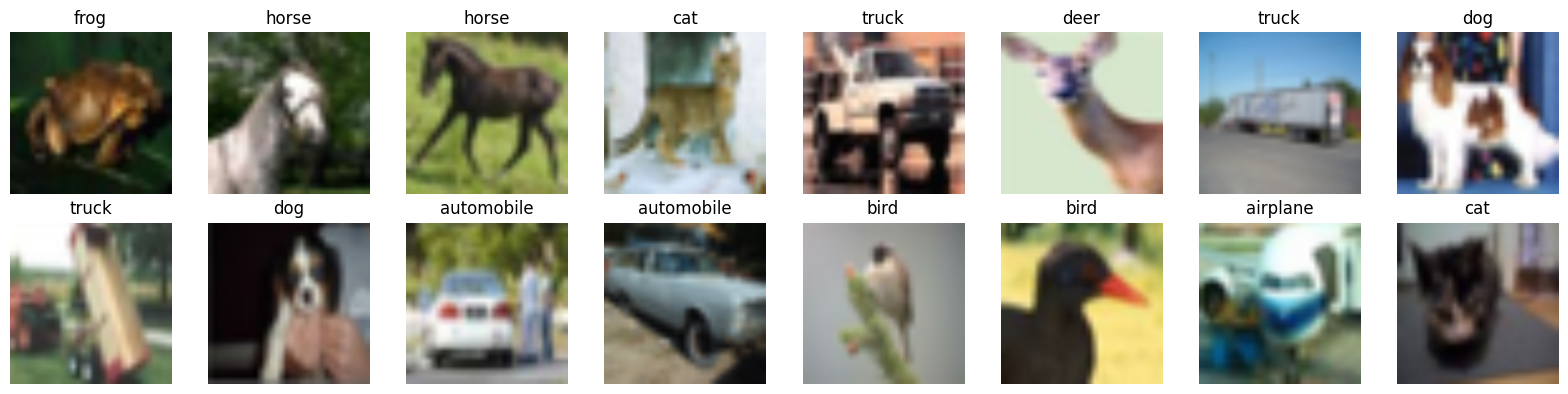

In [5]:
full_train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=preprocess)
full_train_size = len(full_train_ds)
val_size = int(full_train_size * 0.1)

train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [full_train_size - val_size, val_size])
overfit_train_ds, overfit_val_ds, _ = torch.utils.data.random_split(full_train_ds, [16, 16, full_train_size - 32])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2)

overfit_train_loader = DataLoader(overfit_train_ds, batch_size=128, shuffle=False, num_workers=0)
overfit_val_loader = DataLoader(overfit_val_ds, batch_size=128, shuffle=False, num_workers=0)

classnames = full_train_ds.classes
num_classes = len(classnames)

print(f"Val dataset:   {len(val_ds)} images, {num_classes} classes")

def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
    batch = next(iter(dl))
    images, labels = batch
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            label = classnames[labels[idx]]
            axs[i, j].imshow(img)
            axs[i, j].set_title(label)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(val_loader, rows=2, cols=8)

In [6]:
class HardcodedPrompt(nn.Module):
    def __init__(self, clip_model, classnames):
        super().__init__()
        prompts = [f"a photo of a {c}" for c in classnames]
        text_tokens = tokenizer(prompts).to(device)
        text_features = clip_model.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        self.register_buffer("text_features", text_features)

    def forward_text_features(self):
        return self.text_features


In [7]:
class ZeroShotClassifier(nn.Module):
    def __init__(self, clip_model, classnames):
        super().__init__()
        self.model = clip_model
        #self.device = device
        self.classnames = classnames
        self.hardcoded_prompts = HardcodedPrompt(clip_model, classnames)

    def forward(self, images):
        with torch.no_grad():
            images = images.to(device)
            image_features = self.model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = self.hardcoded_prompts.forward_text_features()
            logits = 100.0 * image_features @ text_features.T
        return logits

In [25]:
class CoOpPrompt(nn.Module):
    def __init__(self, clip_model, tokenizer, classnames, n_ctx=16, init_scale=0.02, device="cpu"):
        super().__init__()
        self.model = clip_model
        self.text_tower = getattr(self.model, "text", self.model)
        #self.visual_tower = getattr(self.model, "visual", self.model)
        self.tokenizer = tokenizer
        self.classnames = classnames
        self.device = device

        # Text transformer sizes
        self.context_length = getattr(self.text_tower, "context_length", 77)
        self.width = self.text_tower.token_embedding.weight.shape[1]

        # Learnable context (n_ctx continuous "tokens")
        self.ctx = nn.Parameter(init_scale * torch.randn(n_ctx, self.width, device=device))

        # Tokenize bare classnames (we'll prepend soft context ourselves)
        with torch.no_grad():
            self.class_token_ids = tokenizer(classnames).to(device)  # [C, L]
            # EOT trick: in CLIP tokenization the EOT id is the largest id in each row
            self.eot_indices = self.class_token_ids.argmax(dim=-1)   # [C]

        # Freeze CLIP
        for p in self.text_tower.parameters():
            p.requires_grad = False
        for p in self.model.parameters():
            p.requires_grad = False

    def train(self, mode=True):
        super().train(mode)
        if mode:
          self.model.eval()
          self.text_tower.train()
        else:
          self.model.eval()
          self.text_tower.eval()

    def forward_text_features(self):
        C = len(self.classnames)
        token_ids = self.class_token_ids  # [C, L]

        # Frozen lookup for class tokens
        with torch.no_grad():
            tok_emb = self.text_tower.token_embedding(token_ids)  # [C, L, W]

        sos = tok_emb[:, :1, :]         # [C,1,W]
        class_part = tok_emb[:, 1:, :]  # [C,L-1,W]

        # Learnable context repeated across classes
        ctx = self.ctx.unsqueeze(0).expand(C, -1, -1)  # [C, n_ctx, W]

        # [SOS] + [CTX...CTX] + [class tokens...]
        x = torch.cat([sos, ctx, class_part], dim=1)  # [C, 1+n_ctx+(L-1), W]

        # Pad/truncate to model context length
        L_target = getattr(self.text_tower, "context_length", 77)
        if x.size(1) > L_target:
            x = x[:, :L_target, :]
        elif x.size(1) < L_target:
            pad_len = L_target - x.size(1)
            pad = torch.zeros(C, pad_len, x.size(2), device=self.device, dtype=x.dtype)
            x = torch.cat([x, pad], dim=1)
        L = x.size(1)

        # Dtypes, pos emb, and (optional) attn mask, all sliced to L
        text_dtype = self.text_tower.token_embedding.weight.dtype
        pos = self.text_tower.positional_embedding[:L].to(text_dtype)  # [L,W]

        attn = getattr(self.text_tower, "attn_mask", None)
        if attn is not None:
            attn = attn[:L, :L].to(text_dtype)  # ensure (L,L)

        # Respect transformer.batch_first
        batch_first = getattr(self.text_tower.transformer, "batch_first", False)
        if batch_first:
            # want [N, L, D]
            x = x.to(text_dtype) + pos.unsqueeze(0)   # [C,L,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # stays [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]
        else:
            # want [L, N, D]
            x = (x.to(text_dtype) + pos).permute(1, 0, 2)  # [L,C,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # [L,C,W]
            x = x.permute(1, 0, 2)                         # [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]

        # Pool at EOT (shift by n_ctx), clamp in case of truncation
        eot = (self.eot_indices + self.ctx.shape[0]).clamp(max=L - 1)
        text_emb = x[torch.arange(C, device=self.device), eot] @ self.text_tower.text_projection  # [C,D]

        # Normalize
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        return text_emb

In [26]:
class CoOpClip(nn.Module):
    def __init__(self, clip_model, tokenizer, classnames, n_ctx=16, device="cpu"):
        super().__init__()
        self.model = clip_model
        #self.device = device
        self.classnames = classnames
        self.coop_prompt = CoOpPrompt(clip_model, tokenizer, classnames, n_ctx, 0.02, device)

        self.model.requires_grad_(False)
        self.coop_prompt.requires_grad_(True)

    def train(self, mode: bool=True):
        super().train(mode)
        if mode:
          self.model.eval()
          self.coop_prompt.train()
        else:
          self.model.eval()
          self.coop_prompt.eval()

    def forward(self, images):
        images = images.to(device)
        with torch.no_grad():
            image_features = self.model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = self.coop_prompt.forward_text_features()
        logits = 100.0 * image_features @ text_features.T
        return logits

In [27]:
@torch.no_grad()
def evaluate_coop(model, coop, loader, device, loss_fn, desc="eval", pbar=True):
    """
    Eval loop shaped like evaluate.py, adapted to CLIP+CoOp.

    model: frozen CLIP (open_clip)
    coop:  prompt learner (provides forward_text_features())
    loader: DataLoader yielding (images, labels)
    device: torch.device or str
    loss_fn: criterion (CrossEntropyLoss)
    """
    model.eval()
    loss_sum, correct, count = 0.0, 0, 0
    iterator = tqdm(loader, desc=desc, leave=False) if pbar else loader

    # ctx is fixed during eval; text feats can be computed once
    txt_feat = coop.forward_text_features()  # [C, D]

    for images, labels in iterator:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        img_feat = model.encode_image(images)                # [B, D]
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
        logits = 100.0 * (img_feat @ txt_feat.T)             # [B, C]
        loss = loss_fn(logits, labels)

        bs = labels.size(0)
        loss_sum += loss.item() * bs
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        count += bs

        if pbar:
            acc = (correct / max(1, count)) * 100.0
            iterator.set_postfix(loss=loss.item(), acc=f"{acc:.2f}%")

    avg_loss = loss_sum / max(1, count)
    avg_acc = correct / max(1, count)
    return avg_loss, avg_acc

def train_coop(
    model, tokenizer, classnames, train_loader, val_loader, device="cpu",
    n_ctx=16, epochs=5, batch_size=256, lr=5e-3, num_workers=2,
    val_fraction=0.1, log_interval=25, ema_alpha=0.1
):
    """
    Train CoOp prompts on dataset using a tqdm-style loop like training_loop.py.
    Only coop.ctx is optimized; CLIP remains frozen in eval().
    """
    # --- 1) Module & optimizer
    coop = CoOpPrompt(model, tokenizer, classnames, n_ctx=n_ctx, device=device).to(device)
    optimizer = torch.optim.AdamW([coop.ctx], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # --- 3) Freeze CLIP; we only learn coop.ctx
    model.eval()

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(1, epochs + 1):
        # ---- train epoch (same rhythm as training_loop.py)
        train_sum, train_correct, train_count = 0.0, 0, 0
        ema = None

        iterator = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, (images, labels) in enumerate(iterator, start=1):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # frozen image features
            with torch.no_grad():
                img_feat = model.encode_image(images)                  # [B, D]
                img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

            # prompt-conditioned text features (recomputed as ctx updates)
            txt_feat = coop.forward_text_features()                     # [C, D]
            logits = 100.0 * (img_feat @ txt_feat.T)                    # [B, C]
            loss = loss_fn(logits, labels)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            # stats
            bs = labels.size(0)
            train_sum += loss.item() * bs
            preds = logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_count += bs

            # EMA of loss for tqdm postfix
            ema = loss.item() if ema is None else (1 - ema_alpha) * ema + ema_alpha * loss.item()

            if (step % log_interval == 0) or (step == len(iterator)):
                acc_pct = 100.0 * train_correct / max(1, train_count)
                iterator.set_postfix_str(f"loss(ema)={ema:.4f}  acc={acc_pct:.2f}%")

        avg_train_loss = train_sum / max(1, train_count)
        avg_train_acc  = train_correct / max(1, train_count)

        # ---- validation using the separate evaluate (evaluate.py style)
        avg_val_loss, avg_val_acc = evaluate_coop(
            model, coop, val_loader, device, loss_fn=loss_fn, desc="valid", pbar=True
        )

        # ---- log & history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_acc'].append(avg_val_acc)

        tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
            f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
        )

    return coop, history

In [28]:
@torch.no_grad()
def evaluate_classifier(model, test_loader, device, loss_fn, desc="eval", pbar=True):
  model.eval()
  loss_sum, correct, count = 0.0, 0, 0
  iterator = tqdm(test_loader, desc=desc, leave=False) if pbar else test_loader
  for images, labels in iterator:
    images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    logits = model(images)
    loss = loss_fn(logits, labels)

    bs = labels.size(0)
    loss_sum += loss.item() * bs
    preds = logits.argmax(dim=1)
    correct += (preds == labels).sum().item()
    count += bs

    if pbar:
      acc = (correct / max(1, count)) * 100.0
      iterator.set_postfix(loss=loss.item(), acc=f"{acc:.2f}%")

  avg_loss = loss_sum / max(1, count)
  avg_acc = correct / max(1, count)
  return avg_loss, avg_acc



def train(
    model, tokenizer, classnames, train_loader, val_loader, device="cpu",
    n_ctx=16, epochs=5, batch_size=256, lr=5e-3, num_workers=2,
    val_fraction=0.1, log_interval=25, ema_alpha=0.1
):
    model.to(device)
    model.train()
    print(model.coop_prompt.parameters())
    optimizer = torch.optim.AdamW([model.coop_prompt.ctx], lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(1, epochs + 1):
        # ---- train epoch (same rhythm as training_loop.py)
        train_sum, train_correct, train_count = 0.0, 0, 0
        ema = None
        model.train()

        iterator = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, (images, labels) in enumerate(iterator, start=1):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # frozen image features
            logits = model(images)
            loss = loss_fn(logits, labels)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            # stats
            bs = labels.size(0)
            train_sum += loss.item() * bs
            preds = logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_count += bs

            # EMA of loss for tqdm postfix
            ema = loss.item() if ema is None else (1 - ema_alpha) * ema + ema_alpha * loss.item()

            if (step % log_interval == 0) or (step == len(iterator)):
                acc_pct = 100.0 * train_correct / max(1, train_count)
                iterator.set_postfix_str(f"loss(ema)={ema:.4f}  acc={acc_pct:.2f}%")

        avg_train_loss = train_sum / max(1, train_count)
        avg_train_acc  = train_correct / max(1, train_count)

        # ---- validation using the separate evaluate (evaluate.py style)
        avg_val_loss, avg_val_acc = evaluate_classifier(
            model, val_loader, device, loss_fn=loss_fn, desc="valid", pbar=True
        )

        # ---- log & history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_acc'].append(avg_val_acc)

        tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
            f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
        )

    return history

In [ ]:
# Test zero-shot (hardcodded prompt)
hardcoded_prompt = HardcodedPrompt(model, classnames)

evaluate_coop(
    model=model,
    coop=hardcoded_prompt,
    loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="hardcoded",
    pbar=True
)

hardcoded:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
zero_shot_classifier = ZeroShotClassifier(model, classnames)

evaluate_classifier(
    model=zero_shot_classifier,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing zero-shot classifier on full val",
    pbar=True
)

In [14]:
# Test overfit
overfit_coop, history = train_coop(
    model=model,
    tokenizer=tokenizer,
    classnames=classnames,
    train_loader=overfit_train_loader,
    val_loader=overfit_val_loader,
    device=device,
    n_ctx=cfg.prompt_len,
    epochs=cfg.overfit_epochs,
    batch_size=cfg.batch_size,
    lr=cfg.lr_prompt,
    num_workers=cfg.num_workers,
)

Epoch 1/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 001: train_loss=0.1054  train_acc=100.00%  val_loss=0.0870  val_acc=100.00%


Epoch 2/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 002: train_loss=0.0428  train_acc=100.00%  val_loss=0.0316  val_acc=100.00%


Epoch 3/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 003: train_loss=0.0086  train_acc=100.00%  val_loss=0.0366  val_acc=100.00%


Epoch 4/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 004: train_loss=0.0062  train_acc=100.00%  val_loss=0.0236  val_acc=100.00%


Epoch 5/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 005: train_loss=0.0057  train_acc=100.00%  val_loss=0.0253  val_acc=100.00%


Epoch 6/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 006: train_loss=0.0045  train_acc=100.00%  val_loss=0.0280  val_acc=100.00%


Epoch 7/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 007: train_loss=0.0026  train_acc=100.00%  val_loss=0.0326  val_acc=100.00%


Epoch 8/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 008: train_loss=0.0023  train_acc=100.00%  val_loss=0.0350  val_acc=100.00%


Epoch 9/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 009: train_loss=0.0019  train_acc=100.00%  val_loss=0.0402  val_acc=100.00%


Epoch 10/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 010: train_loss=0.0017  train_acc=100.00%  val_loss=0.0472  val_acc=100.00%


Epoch 11/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 011: train_loss=0.0014  train_acc=100.00%  val_loss=0.0414  val_acc=100.00%


Epoch 12/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 012: train_loss=0.0014  train_acc=100.00%  val_loss=0.0452  val_acc=100.00%


Epoch 13/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 013: train_loss=0.0013  train_acc=100.00%  val_loss=0.0469  val_acc=100.00%


Epoch 14/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 014: train_loss=0.0013  train_acc=100.00%  val_loss=0.0477  val_acc=100.00%


Epoch 15/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 015: train_loss=0.0013  train_acc=100.00%  val_loss=0.0471  val_acc=100.00%


Epoch 16/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 016: train_loss=0.0012  train_acc=100.00%  val_loss=0.0481  val_acc=100.00%


Epoch 17/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 017: train_loss=0.0011  train_acc=100.00%  val_loss=0.0475  val_acc=100.00%


Epoch 18/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 018: train_loss=0.0010  train_acc=100.00%  val_loss=0.0428  val_acc=100.00%


Epoch 19/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 019: train_loss=0.0009  train_acc=100.00%  val_loss=0.0419  val_acc=100.00%


Epoch 20/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 020: train_loss=0.0009  train_acc=100.00%  val_loss=0.0400  val_acc=100.00%


Epoch 21/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 021: train_loss=0.0008  train_acc=100.00%  val_loss=0.0400  val_acc=100.00%


Epoch 22/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 022: train_loss=0.0007  train_acc=100.00%  val_loss=0.0359  val_acc=100.00%


Epoch 23/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 023: train_loss=0.0007  train_acc=100.00%  val_loss=0.0383  val_acc=100.00%


Epoch 24/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 024: train_loss=0.0006  train_acc=100.00%  val_loss=0.0377  val_acc=100.00%


Epoch 25/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 025: train_loss=0.0006  train_acc=100.00%  val_loss=0.0374  val_acc=100.00%


Epoch 26/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 026: train_loss=0.0006  train_acc=100.00%  val_loss=0.0369  val_acc=100.00%


Epoch 27/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 027: train_loss=0.0005  train_acc=100.00%  val_loss=0.0355  val_acc=100.00%


Epoch 28/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 028: train_loss=0.0004  train_acc=100.00%  val_loss=0.0317  val_acc=100.00%


Epoch 29/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 029: train_loss=0.0004  train_acc=100.00%  val_loss=0.0344  val_acc=100.00%


Epoch 30/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 030: train_loss=0.0005  train_acc=100.00%  val_loss=0.0317  val_acc=100.00%


Epoch 31/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 031: train_loss=0.0004  train_acc=100.00%  val_loss=0.0328  val_acc=100.00%


Epoch 32/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 032: train_loss=0.0003  train_acc=100.00%  val_loss=0.0331  val_acc=100.00%


Epoch 33/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 033: train_loss=0.0003  train_acc=100.00%  val_loss=0.0332  val_acc=100.00%


Epoch 34/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 034: train_loss=0.0003  train_acc=100.00%  val_loss=0.0331  val_acc=100.00%


Epoch 35/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 035: train_loss=0.0003  train_acc=100.00%  val_loss=0.0330  val_acc=100.00%


Epoch 36/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 036: train_loss=0.0003  train_acc=100.00%  val_loss=0.0329  val_acc=100.00%


Epoch 37/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 037: train_loss=0.0003  train_acc=100.00%  val_loss=0.0326  val_acc=100.00%


Epoch 38/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 038: train_loss=0.0003  train_acc=100.00%  val_loss=0.0321  val_acc=100.00%


Epoch 39/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 039: train_loss=0.0002  train_acc=100.00%  val_loss=0.0316  val_acc=100.00%


Epoch 40/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 040: train_loss=0.0002  train_acc=100.00%  val_loss=0.0311  val_acc=100.00%


Epoch 41/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 041: train_loss=0.0002  train_acc=100.00%  val_loss=0.0308  val_acc=100.00%


Epoch 42/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 042: train_loss=0.0002  train_acc=100.00%  val_loss=0.0302  val_acc=100.00%


Epoch 43/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 043: train_loss=0.0002  train_acc=100.00%  val_loss=0.0297  val_acc=100.00%


Epoch 44/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 044: train_loss=0.0002  train_acc=100.00%  val_loss=0.0294  val_acc=100.00%


Epoch 45/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 045: train_loss=0.0002  train_acc=100.00%  val_loss=0.0292  val_acc=100.00%


Epoch 46/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 046: train_loss=0.0002  train_acc=100.00%  val_loss=0.0293  val_acc=100.00%


Epoch 47/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 047: train_loss=0.0002  train_acc=100.00%  val_loss=0.0293  val_acc=100.00%


Epoch 48/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 048: train_loss=0.0002  train_acc=100.00%  val_loss=0.0293  val_acc=100.00%


Epoch 49/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 049: train_loss=0.0001  train_acc=100.00%  val_loss=0.0293  val_acc=100.00%


Epoch 50/50 | train:   0%|          | 0/1 [00:00<?, ?it/s]

valid:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 050: train_loss=0.0001  train_acc=100.00%  val_loss=0.0293  val_acc=100.00%


In [30]:
coopclip_model = CoOpClip(
    clip_model=model,
    tokenizer=tokenizer,
    classnames=classnames,
    n_ctx=cfg.prompt_len,
    device=device
)

loss, acc = evaluate_classifier(
    model=coopclip_model,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing CoOpClip on full val",
    pbar=True
)
print(f"Accuracy before training: {acc}")

history = train(
    model=coopclip_model,
    tokenizer=tokenizer,
    classnames=classnames,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    n_ctx=cfg.prompt_len,
    epochs=cfg.max_epochs,
    batch_size=cfg.batch_size,
    lr=cfg.lr_prompt,
    num_workers=cfg.num_workers,
)

Testing CoOpClip on full val:   0%|          | 0/40 [00:00<?, ?it/s]

Accuracy before training: 0.948
<generator object Module.parameters at 0x789a037a1380>


Epoch 1/10 | train:   0%|          | 0/352 [00:00<?, ?it/s]

valid:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 001: train_loss=0.1154  train_acc=96.08%  val_loss=0.0981  val_acc=96.78%


Epoch 2/10 | train:   0%|          | 0/352 [00:00<?, ?it/s]

valid:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 002: train_loss=0.0990  train_acc=96.60%  val_loss=0.0920  val_acc=96.86%


Epoch 3/10 | train:   0%|          | 0/352 [00:00<?, ?it/s]

valid:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 003: train_loss=0.0934  train_acc=96.86%  val_loss=0.0903  val_acc=96.98%


Epoch 4/10 | train:   0%|          | 0/352 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789b2155d300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789b2155d300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/40 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789b2155d300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x789b2155d300> 
 ^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^^if w.is_alive():^
^ 
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
     ^^ ^^ ^^ ^ ^ ^^ ^ ^^^
^  File "/

Epoch 004: train_loss=0.0902  train_acc=97.02%  val_loss=0.0900  val_acc=96.98%


Epoch 5/10 | train:   0%|          | 0/352 [00:00<?, ?it/s]

valid:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 005: train_loss=0.0880  train_acc=97.06%  val_loss=0.0894  val_acc=97.12%


Epoch 6/10 | train:   0%|          | 0/352 [00:00<?, ?it/s]

valid:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 006: train_loss=0.0864  train_acc=97.13%  val_loss=0.0895  val_acc=96.98%


Epoch 7/10 | train:   0%|          | 0/352 [00:00<?, ?it/s]

valid:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 007: train_loss=0.0850  train_acc=97.18%  val_loss=0.0884  val_acc=97.14%


Epoch 8/10 | train:   0%|          | 0/352 [00:00<?, ?it/s]

valid:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 008: train_loss=0.0837  train_acc=97.20%  val_loss=0.0876  val_acc=97.06%


Epoch 9/10 | train:   0%|          | 0/352 [00:00<?, ?it/s]

valid:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 009: train_loss=0.0826  train_acc=97.20%  val_loss=0.0867  val_acc=97.06%


Epoch 10/10 | train:   0%|          | 0/352 [00:00<?, ?it/s]

valid:   0%|          | 0/40 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x789b2155d300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x789b2155d300>
Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    ^if w.is_alive():^^
 ^^ ^ 
     File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^^  ^  ^^  ^ ^^ 
  ^  File "/us

Epoch 010: train_loss=0.0816  train_acc=97.28%  val_loss=0.0862  val_acc=97.04%


In [31]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    ax = axes[0]
    ax.plot(epochs, history['train_loss'], label='train')
    ax.plot(epochs, history['val_loss'], label='val')
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss'); ax.set_title('Loss'); ax.legend()

    ax = axes[1]
    if 'train_acc' in history and 'val_acc' in history:
        ax.plot(epochs, [x * 100 for x in history['train_acc']], label='train')
        ax.plot(epochs, [x * 100 for x in history['val_acc']], label='val')
        ax.set_ylabel('Accuracy (%)')
    else:
        ax.text(0.5, 0.5, 'No accuracy in history', ha='center', va='center', transform=ax.transAxes)
    ax.set_xlabel('Epoch'); ax.set_title('Accuracy'); ax.legend()
    plt.show()

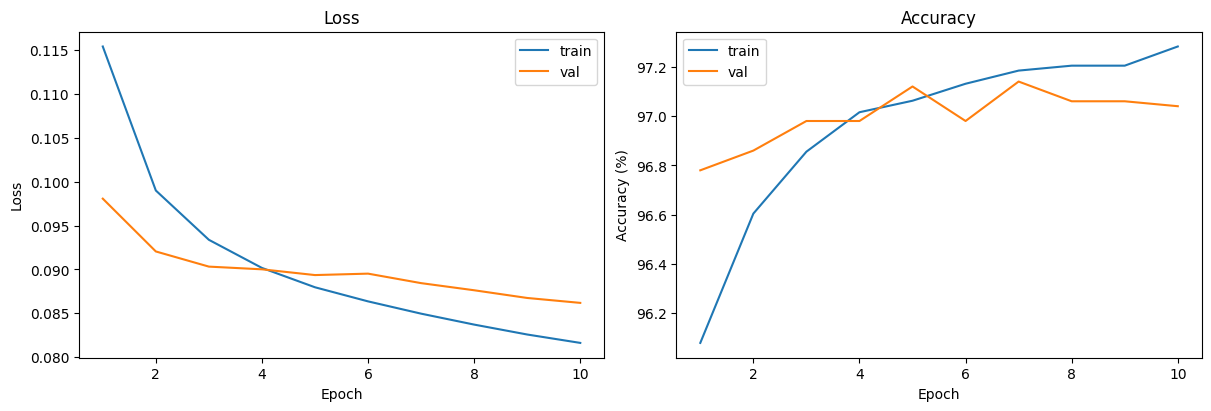

In [32]:
plot_history(history)

In [35]:
import torch, hashlib, json

def save_coop_prompt(coop_prompt: nn.Module, path: str, *,
                     model_name: str, pretrained: str, classnames: list, n_ctx: int):
    # minimal payload: the ctx tensor + metadata to sanity-check at load time
    payload = {
        "ctx": coop_prompt.ctx.detach().cpu(),  # device-agnostic
        "meta": {
            "model_name": model_name,
            "pretrained": pretrained,
            "n_ctx": int(n_ctx),
            "classnames": list(classnames),
            # quick fingerprint to catch class order changes
            "classnames_sha1": hashlib.sha1(
                json.dumps(list(classnames), ensure_ascii=False).encode("utf-8")
            ).hexdigest(),
        }
    }
    torch.save(payload, path)


In [36]:
save_coop_prompt(coopclip_model.coop_prompt, "cifar10_mobileclip2-s0_ctx.pt",
                 model_name=cfg.model_name, pretrained=cfg.pretrained,
                 classnames=classnames, n_ctx=cfg.prompt_len)

In [43]:
from PIL import Image
image = Image.open("dog.jpg")
logits = coopclip_model(preprocess(image).unsqueeze(0))
pred = logits.argmax(1)
pred_class = classnames[pred]
print(f"The image is a {pred_class}")

The image is a dog


In [ ]:
#coop, history = train_coop(
#    model=model,
#    tokenizer=tokenizer,
#    classnames=classnames,
#    train_loader=train_loader,
#    val_loader=val_loader,
#    device=device,
#    n_ctx=cfg.prompt_len,
#    epochs=cfg.max_epochs,
#    batch_size=cfg.batch_size,
#    lr=cfg.lr_prompt,
#    num_workers=cfg.num_workers,
#)